# QAOA for solving the MaxCut problem

Project realised for the "Introduction to Quantum Research for Girls 2024" program organized by Physics Beyond and Girls In Quantum.

- Project name: Optimization problem for QAOA
- Group members: Gana Gangadharan, Gabriella Xenia Talarico
- Mentor: Vanessa Dehn, Fraunhofer IAF

### Introduction

The MaxCut problem is a Combinatorial Optimization problem (CO) which can be also expressed as a QUBO problem (Quadratic Unconstrained Optimization Problem). Thus, it can be tackled by a quantum computer due to the fact that its QUBO expression can be translated to a cost hamiltonian $H_c$. The ground state of the hamiltonian, which corresponds to the solution of the instance QUBO problem, can be found using the QAOA algorithm. 

##### Graph theory and MaxCut

To define the MaxCut problem we should be familiar with the concept of a graph. A graph G(V, E) is a mathematical structure comprising a set of vertices V and a set of edges E, which can also be seen as unordered paris of vertices. Let's create a graph using the NetworkX library. NetworkX is a Python package for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks.

In [56]:
!pip install networkx

First, we create our graph structure.

In [2]:
import networkx as nx

# Create the graph object and add nodes
G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3, 4, 5])

# Define the edges with weights and add them to the graph
edge_list = [(0, 1, 1.0), (0, 2, 1.0), (1, 3, 1.0), (2, 3, 1.0), (3, 4, 1.0), (4, 5, 1.0)]
G.add_weighted_edges_from(edge_list)

# Let's define the global variable which will store the number of nodes
N_QUBITS = G.size()

In [3]:
def draw_graph(G):    
    nx.draw(G, with_labels=True, alpha=0.8, node_size=500)

In [4]:
def draw_coloured_graph(G, colors):    
    nx.draw(G, with_labels=True, node_color=colors, alpha=0.8, node_size=500)

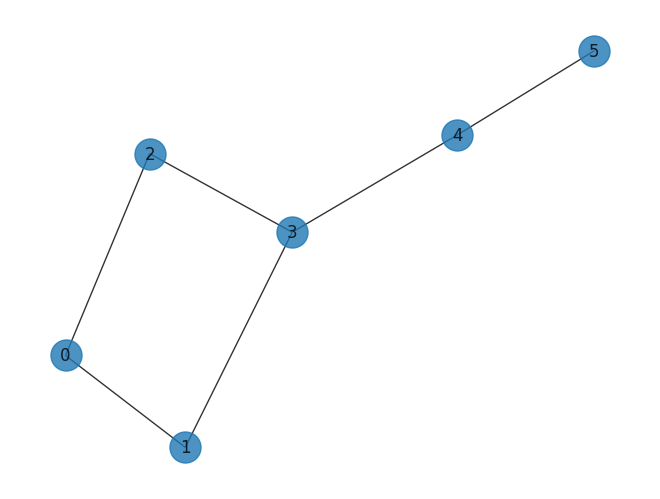

In [5]:
draw_graph(G)

In the Max-Cut problem we want to divide the nodes into two sets, such that the number of edges in between is maximum.

<img src="images/graph_maxcut.png" alt="Our example graph" width="700"/>


In the example above we have three examples of partitioning the nodes of the graph into two sets, "light-blue" (0) and "purple" (1).

For 2 nodes, as each node can be assigned to either the "light-blue" or "purple" sets, there are $2^6 = 64$ possible assignments, out of which we have to find one that gives maximum number of edges between the sets. To solve the problem in a classical manner we should use an exhaustion algorithm which tries all the possible assignments.


### Bruteforce : the classical solution

In [61]:
!pip install numpy

In [6]:
import numpy as np

# Computing the weight matrix from the random graph
n = N_QUBITS
w = np.zeros([n, n])

for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i, j, default=0)
        if temp != 0:
            w[i, j] = temp["weight"]
print(w)

[[0. 1. 1. 0. 0. 0.]
 [1. 0. 0. 1. 0. 0.]
 [1. 0. 0. 1. 0. 0.]
 [0. 1. 1. 0. 1. 0.]
 [0. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 1. 0.]]


The weight matrix that we got represents the edges of the graph

<img src="images/weight_matrix.png" alt="Weight Matrix" width="600"/>

case = [0, 0, 0, 0, 0, 0] cost = 0.0
case = [1, 0, 0, 0, 0, 0] cost = 2.0
case = [0, 1, 0, 0, 0, 0] cost = 2.0
case = [1, 1, 0, 0, 0, 0] cost = 2.0
case = [0, 0, 1, 0, 0, 0] cost = 2.0
case = [1, 0, 1, 0, 0, 0] cost = 2.0
case = [0, 1, 1, 0, 0, 0] cost = 4.0
case = [1, 1, 1, 0, 0, 0] cost = 2.0
case = [0, 0, 0, 1, 0, 0] cost = 3.0
case = [1, 0, 0, 1, 0, 0] cost = 5.0
case = [0, 1, 0, 1, 0, 0] cost = 3.0
case = [1, 1, 0, 1, 0, 0] cost = 3.0
case = [0, 0, 1, 1, 0, 0] cost = 3.0
case = [1, 0, 1, 1, 0, 0] cost = 3.0
case = [0, 1, 1, 1, 0, 0] cost = 3.0
case = [1, 1, 1, 1, 0, 0] cost = 1.0
case = [0, 0, 0, 0, 1, 0] cost = 2.0
case = [1, 0, 0, 0, 1, 0] cost = 4.0
case = [0, 1, 0, 0, 1, 0] cost = 4.0
case = [1, 1, 0, 0, 1, 0] cost = 4.0
case = [0, 0, 1, 0, 1, 0] cost = 4.0
case = [1, 0, 1, 0, 1, 0] cost = 4.0
case = [0, 1, 1, 0, 1, 0] cost = 6.0
case = [1, 1, 1, 0, 1, 0] cost = 4.0
case = [0, 0, 0, 1, 1, 0] cost = 3.0
case = [1, 0, 0, 1, 1, 0] cost = 5.0
case = [0, 1, 0, 1, 1, 0] cost = 3.0
c

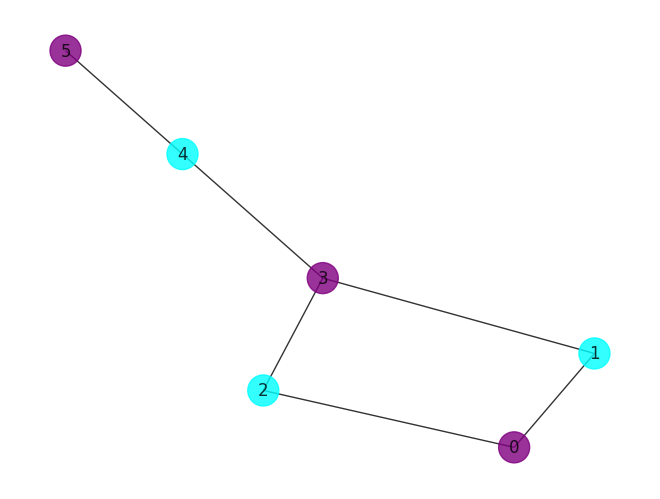

In [7]:
best_cost_brute = 0 # This variable will hold the maximum number of cuts

# The number of iterations is 2^n
for b in range(2**n):
    # x contains the reversed binary representation of b
    # example: b = 5, x = [1, 0, 1, 0, 0, 0]
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))] # The configuration
    
    cost = 0
    for i in range(n):
        for j in range(n):
            cost = cost + w[i, j] * x[i] * (1 - x[j]) # Cost function of MaxCut

    # Update the maximum number of cuts if needed
    if best_cost_brute < cost:
        best_cost_brute = cost
        xbest_brute = x
    print("case = " + str(x) + " cost = " + str(cost))

# Print the best solution found
colors = ["purple" if xbest_brute[i] == 0 else "cyan" for i in range(n)]
draw_coloured_graph(G, colors)
print("\nBest solution = " + str(xbest_brute) + " cost = " + str(best_cost_brute))

As we can see, as the number of nodes in the graph increases, the number of possible assignments increases exponentially.

### Make it quantum

Solving qubo problem in classical computer is challenging as it solve qubo problem by checking every possible combination of variable states. However, as we have seen, this approach quickly becomes intractable for even moderately sized problems, leading to an exponential explosion in computation time.QUBOs are NP-hard in general which means that we cannot expect to solve such problems in feasible time on classic computers. 

Every QUBO can be transformed to an Ising model, therefore, QUBOs can be solved on quantum computers through quantum annealing or variational algorithms like QAOA.

In QAOA,we encode QUBO instances as an Hamiltonian problem. For this,we need to find the Hamiltonian which encodes our cost function. Then Qubo problem just becomes finding ground state of the Cost Hamiltonian.

In our case, the Cost Hamiltonian is the following:
$$
\begin{align*}
H_C = & \tfrac{1}{2} \big(Z_0 \otimes Z_1 \otimes I_2 \otimes I_3 \otimes I_4 \otimes I_5 \big) + \\
      & \tfrac{1}{2} \big(Z_0 \otimes I_1 \otimes Z_2 \otimes I_3 \otimes I_4 \otimes I_5 \big) + \\
      & \tfrac{1}{2} \big(I_0 \otimes Z_1 \otimes I_2 \otimes Z_3 \otimes I_4 \otimes I_5 \big) + \\
      & \tfrac{1}{2} \big(I_0 \otimes I_1 \otimes Z_2 \otimes Z_3 \otimes I_4 \otimes I_5 \big) + \\
      & \tfrac{1}{2} \big(I_0 \otimes I_1 \otimes I_2 \otimes Z_3 \otimes Z_4 \otimes I_5 \big) + \\
      & \tfrac{1}{2} \big(I_0 \otimes I_1 \otimes I_2 \otimes I_3 \otimes Z_4 \otimes Z_5 \big)
\end{align*}
$$

The key thing to note in this matrix is the fact that each pair of $Z$ gates in the Hamiltonian is actually representing an edge.

<img src="images/cost_hamiltonian.png" alt="Cost Hamiltonian" width="600"/>

### The layers of the QAOA algorithm

As we explained, the Cost Hamiltonian is a fundamental part of the solution we are looking for. Now we will deepen in the understanding of its role in the QAOA algorithm.

The structure of the algorithm is the following:
1. Preparation of equal superposition state (Applying Hadamard gates to all the qubits involved)
2. $p$ repetitions of alternating **cost layers** and **mixed layers**
3. Measurement in computational basis

After these steps we evaluate the mean of cut values and use a classical optimizer to update the parameters on which the cost layers and mixed layers rely upon. This allows to improve the paramethers which will be fed into the algorithm again.

### Preparation for performing QAOA

In [ ]:
!pip install qiskit
!pip install qiskit_aer

In [8]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit_aer import Aer
from qiskit.circuit import Parameter
#from qiskit import execute

To perform the algorithm we need to create in advance the circuit that performs the preparation of equal superposition states and the **unitaries** that represent Cost Layer and Mixed Layer.

#### Preparation of equal superposition state


In [9]:
qc_0 = QuantumCircuit(N_QUBITS)
for i in range(N_QUBITS):
    qc_0.h(i)

qc_0.draw()

┌───┐
q_0: ┤ H ├
     ├───┤
q_1: ┤ H ├
     ├───┤
q_2: ┤ H ├
     ├───┤
q_3: ┤ H ├
     ├───┤
q_4: ┤ H ├
     ├───┤
q_5: ┤ H ├
     └───┘

#### Cost layer

The Cost Layer's Unitary operator is the following: 
$$
\begin{align*}
U(H_P) = e^{-i \gamma H_P}
\end{align*}
$$

Since in our example $H_P$ is
$$
\begin{align*}
H_P = & \tfrac{1}{2} \big(Z_0 \otimes Z_1 \otimes I_2 \otimes I_3 \otimes I_4 \otimes I_5 \big) + \\
      & \tfrac{1}{2} \big(Z_0 \otimes I_1 \otimes Z_2 \otimes I_3 \otimes I_4 \otimes I_5 \big) + \\
      & \tfrac{1}{2} \big(I_0 \otimes Z_1 \otimes I_2 \otimes Z_3 \otimes I_4 \otimes I_5 \big) + \\
      & \tfrac{1}{2} \big(I_0 \otimes I_1 \otimes Z_2 \otimes Z_3 \otimes I_4 \otimes I_5 \big) + \\
      & \tfrac{1}{2} \big(I_0 \otimes I_1 \otimes I_2 \otimes Z_3 \otimes Z_4 \otimes I_5 \big) + \\
      & \tfrac{1}{2} \big(I_0 \otimes I_1 \otimes I_2 \otimes I_3 \otimes Z_4 \otimes Z_5 \big)
\end{align*}
$$

The Cost Layer for our example problem is
$$
\begin{align*}
U(H_P) = e^{-i \gamma H_P} = e^{-i \gamma Z_0 Z_1} e^{-i \gamma Z_0 Z_2} e^{-i \gamma Z_1 Z_3} e^{-i \gamma Z_2 Z_3} e^{-i \gamma Z_3 Z_4} e^{-i \gamma Z_4 Z_5}
\end{align*}
$$

$U_c(\gamma_1)$

In summary:
- The Cost Layer depends on the paramether $\gamma$. 
- The gates involved are $R_Z$ gates which perform a single-qubit rotation about the Z axis with angle $\gamma$

In [10]:
gamma = Parameter("$\\gamma$")
qc_p = QuantumCircuit(N_QUBITS)
for pair in list(G.edges()):  # pairs of nodes
    qc_p.rzz(2 * gamma, pair[0], pair[1])
    qc_p.barrier()

#qc_p.draw('mpl')
qc_p.decompose().draw()

░                              ░      »
q_0: ──■──────────────────────■───░───■──────────────────────■───░──────»
     ┌─┴─┐┌────────────────┐┌─┴─┐ ░   │                      │   ░      »
q_1: ┤ X ├┤ Rz(2*$\gamma$) ├┤ X ├─░───┼──────────────────────┼───░───■──»
     └───┘└────────────────┘└───┘ ░ ┌─┴─┐┌────────────────┐┌─┴─┐ ░   │  »
q_2: ─────────────────────────────░─┤ X ├┤ Rz(2*$\gamma$) ├┤ X ├─░───┼──»
                                  ░ └───┘└────────────────┘└───┘ ░ ┌─┴─┐»
q_3: ─────────────────────────────░──────────────────────────────░─┤ X ├»
                                  ░                              ░ └───┘»
q_4: ─────────────────────────────░──────────────────────────────░──────»
                                  ░                              ░      »
q_5: ─────────────────────────────░──────────────────────────────░──────»
                                  ░                              ░      »
«                             ░                              ░      »
«q_0: ────────────────────────░──────────────────────────────░──────»
«                             ░                              ░      »
«q_1: ────────────────────■───░──────────────────────────────░──────»
«                         │   ░                              ░      »
«q_2: ────────────────────┼───░───■──────────────────────■───░──────»
«     ┌────────────────┐┌─┴─┐ ░ ┌─┴─┐┌────────────────┐┌─┴─┐ ░      »
«q_3: ┤ Rz(2*$\gamma$) ├┤ X ├─░─┤ X ├┤ Rz(2*$\gamma$) ├┤ X ├─░───■──»
«     └────────────────┘└───┘ ░ └───┘└────────────────┘└───┘ ░ ┌─┴─┐»
«q_4: ────────────────────────░──────────────────────────────░─┤ X ├»
«                             ░                              ░ └───┘»
«q_5: ────────────────────────░──────────────────────────────░──────»
«                             ░                              ░      »
«                             ░                              ░ 
«q_0: ────────────────────────░──────────────────────────────░─
«                             ░                              ░ 
«q_1: ────────────────────────░──────────────────────────────░─
«                             ░                              ░ 
«q_2: ────────────────────────░──────────────────────────────░─
«                             ░                              ░ 
«q_3: ────────────────────■───░──────────────────────────────░─
«     ┌────────────────┐┌─┴─┐ ░                              ░ 
«q_4: ┤ Rz(2*$\gamma$) ├┤ X ├─░───■──────────────────────■───░─
«     └────────────────┘└───┘ ░ ┌─┴─┐┌────────────────┐┌─┴─┐ ░ 
«q_5: ────────────────────────░─┤ X ├┤ Rz(2*$\gamma$) ├┤ X ├─░─
«                             ░ └───┘└────────────────┘└───┘ ░

#### Mixed layer

The Mixed Layer's Unitary operator is the following: 
$$
\begin{align*}
U(H_B) = e^{-i \beta H_B}
\end{align*}
$$

In general $H_B$ is defined as follows
$$
\begin{align*}
H_P = & \big(X_0 \otimes I_1 \otimes I_2 \otimes I_3 \otimes I_4 \otimes I_5 \big) + \\
      & \big(I_0 \otimes X_1 \otimes I_2 \otimes I_3 \otimes I_4 \otimes I_5 \big) + \\
      & \big(I_0 \otimes I_1 \otimes X_2 \otimes I_3 \otimes I_4 \otimes I_5 \big) + \\
      & \big(I_0 \otimes I_1 \otimes I_2 \otimes X_3 \otimes I_4 \otimes I_5 \big) + \\
      & \big(I_0 \otimes I_1 \otimes I_2 \otimes I_3 \otimes X_4 \otimes I_5 \big) + \\
      & \big(I_0 \otimes I_1 \otimes I_2 \otimes I_3 \otimes I_4 \otimes X_5 \big)
\end{align*}
$$

Therefore, the Mixed Layer's Unitary for our exaple can be also written as:
$$
\begin{align*}
U(H_B) = e^{-i \beta H_B} = e^{-i \beta X_0} e^{-i \beta X_1} e^{-i \beta X_2} e^{-i \beta X_3} e^{-i \beta X_4} e^{-i \beta X_5} 
\end{align*}
$$

In [11]:
beta = Parameter("$\\beta$")
qc_mix = QuantumCircuit(N_QUBITS)
for i in range(0, N_QUBITS):
    qc_mix.rx(2 * beta, i)
qc_mix.decompose().draw()

┌────────────────┐
q_0: ┤ R(2*$\beta$,0) ├
     ├────────────────┤
q_1: ┤ R(2*$\beta$,0) ├
     ├────────────────┤
q_2: ┤ R(2*$\beta$,0) ├
     ├────────────────┤
q_3: ┤ R(2*$\beta$,0) ├
     ├────────────────┤
q_4: ┤ R(2*$\beta$,0) ├
     ├────────────────┤
q_5: ┤ R(2*$\beta$,0) ├
     └────────────────┘

### The QAOA circuit

Let's put everything together!
1. Preparation of equal superposition states
2. Applying the unitary corresponding to the problem Hamiltonian
3. Applying the mixing unitary

In [12]:
qc_qaoa = QuantumCircuit(N_QUBITS)
qc_qaoa.append(qc_0, range(N_QUBITS))
qc_qaoa.append(qc_p, range(N_QUBITS))
qc_qaoa.append(qc_mix, range(N_QUBITS))

qc_qaoa.decompose().decompose().draw()

┌─────────┐                             ░                              ░ »
q_0: ┤ U2(0,π) ├──■──────────────────────■───░───■──────────────────────■───░─»
     ├─────────┤┌─┴─┐┌────────────────┐┌─┴─┐ ░   │                      │   ░ »
q_1: ┤ U2(0,π) ├┤ X ├┤ Rz(2*$\gamma$) ├┤ X ├─░───┼──────────────────────┼───░─»
     ├─────────┤└───┘└────────────────┘└───┘ ░ ┌─┴─┐┌────────────────┐┌─┴─┐ ░ »
q_2: ┤ U2(0,π) ├─────────────────────────────░─┤ X ├┤ Rz(2*$\gamma$) ├┤ X ├─░─»
     ├─────────┤                             ░ └───┘└────────────────┘└───┘ ░ »
q_3: ┤ U2(0,π) ├─────────────────────────────░──────────────────────────────░─»
     ├─────────┤                             ░                              ░ »
q_4: ┤ U2(0,π) ├─────────────────────────────░──────────────────────────────░─»
     ├─────────┤                             ░                              ░ »
q_5: ┤ U2(0,π) ├─────────────────────────────░──────────────────────────────░─»
     └─────────┘                             ░                              ░ »
«                                  ░                              ░      »
«q_0: ─────────────────────────────░──────────────────────────────░──────»
«                                  ░                              ░      »
«q_1: ──■──────────────────────■───░──────────────────────────────░──────»
«       │                      │   ░                              ░      »
«q_2: ──┼──────────────────────┼───░───■──────────────────────■───░──────»
«     ┌─┴─┐┌────────────────┐┌─┴─┐ ░ ┌─┴─┐┌────────────────┐┌─┴─┐ ░      »
«q_3: ┤ X ├┤ Rz(2*$\gamma$) ├┤ X ├─░─┤ X ├┤ Rz(2*$\gamma$) ├┤ X ├─░───■──»
«     └───┘└────────────────┘└───┘ ░ └───┘└────────────────┘└───┘ ░ ┌─┴─┐»
«q_4: ─────────────────────────────░──────────────────────────────░─┤ X ├»
«                                  ░                              ░ └───┘»
«q_5: ─────────────────────────────░──────────────────────────────░──────»
«                                  ░                              ░      »
«                             ░                              ░ »
«q_0: ────────────────────────░──────────────────────────────░─»
«                             ░                              ░ »
«q_1: ────────────────────────░──────────────────────────────░─»
«                             ░                              ░ »
«q_2: ────────────────────────░──────────────────────────────░─»
«                             ░                              ░ »
«q_3: ────────────────────■───░──────────────────────────────░─»
«     ┌────────────────┐┌─┴─┐ ░                              ░ »
«q_4: ┤ Rz(2*$\gamma$) ├┤ X ├─░───■──────────────────────■───░─»
«     └────────────────┘└───┘ ░ ┌─┴─┐┌────────────────┐┌─┴─┐ ░ »
«q_5: ────────────────────────░─┤ X ├┤ Rz(2*$\gamma$) ├┤ X ├─░─»
«                             ░ └───┘└────────────────┘└───┘ ░ »
«     ┌────────────────┐
«q_0: ┤ R(2*$\beta$,0) ├
«     ├────────────────┤
«q_1: ┤ R(2*$\beta$,0) ├
«     ├────────────────┤
«q_2: ┤ R(2*$\beta$,0) ├
«     ├────────────────┤
«q_3: ┤ R(2*$\beta$,0) ├
«     ├────────────────┤
«q_4: ┤ R(2*$\beta$,0) ├
«     ├────────────────┤
«q_5: ┤ R(2*$\beta$,0) ├
«     └────────────────┘

The circuit is ready, now we should use a classical optimization algorithm which will find the optimal parameters $\gamma$ and $\beta$ so that the expectation value is minimized.

<img src="images/QAOA.png" alt="QAOA" width="300"/>

In [13]:
def maxcut_obj(solution, graph):
    """Given a bit string as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    Args:
        solution: (str) solution bit string
        graph: networkx graph
    Returns:
        obj: (float) Objective
    """
    # pylint: disable=invalid-name
    obj = 0
    for i, j in graph.edges():
        if solution[i] != solution[j]:
            obj -= 1
    return obj


def compute_expectation(counts, graph):
    """Computes expectation value based on measurement results
    Args:
        counts: (dict) key as bit string, val as count
        graph: networkx graph
    Returns:
        avg: float
             expectation value
    """
    avg = 0
    sum_count = 0
    for bit_string, count in counts.items():
        obj = maxcut_obj(bit_string, graph)
        avg += obj * count
        sum_count += count
    return avg/sum_count


# We will also bring the different circuit components that
# build the qaoa circuit under a single function
def create_qaoa_circ(graph, theta):
    """Creates a parametrized qaoa circuit
    Args:
        graph: networkx graph
        theta: (list) unitary parameters
    Returns:
        (QuantumCircuit) qiskit circuit
    """
    nqubits = len(graph.nodes())
    n_layers = len(theta)//2  # number of alternating unitaries
    beta = theta[:n_layers]
    gamma = theta[n_layers:]

    qc = QuantumCircuit(nqubits)

    # initial_state
    qc.h(range(nqubits))

    for layer_index in range(n_layers):
        # problem unitary
        for pair in list(graph.edges()):
            qc.rzz(2 * gamma[layer_index], pair[0], pair[1])
        # mixer unitary
        for qubit in range(nqubits):
            qc.rx(2 * beta[layer_index], qubit)

    qc.measure_all()
    return qc


# Finally we write a function that executes the circuit
# on the chosen backend
def get_expectation(graph, shots=512):
    """Runs parametrized circuit
    Args:
        graph: networkx graph
    """
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots

    def execute_circ(theta):
        qc = create_qaoa_circ(graph, theta)
        counts = backend.run(qc, seed_simulator=10,
                             nshots=512).result().get_counts()
        return compute_expectation(counts, graph)

    return execute_circ

In [14]:
from scipy.optimize import minimize
expectation = get_expectation(G)
res = minimize(expectation,
               [1.0, 1.0],
               method='COBYLA')
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3.5546875
       x: [ 2.830e+00  4.840e-01]
    nfev: 32
   maxcv: 0.0

#### Analyzing the results

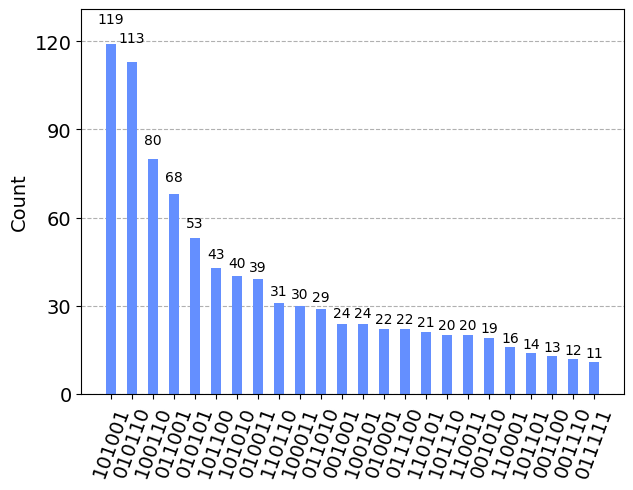

In [15]:
backend = Aer.get_backend('aer_simulator')
backend.shots = 512

from qiskit.visualization import plot_histogram
qc_res = create_qaoa_circ(G, res.x)
counts = backend.run(qc_res, seed_simulator=10).result().get_counts()

plot_histogram(counts, number_to_keep=24, sort="value_desc")

As we can see we get as first results either 100101 or 011010 which are equivalent in term of cuts (6 cuts) and so represent the optimal solutions to our example graph.

#### References:
1. Farhi, Edward, Jeffrey Goldstone, and Sam Gutmann. \"A quantum approximate optimization algorithm.\" arXiv preprint [arXiv:1411.4028 (2014)](https://arxiv.org/abs/1411.4028).
2. Qiskit textbook. \"Solving combinatorial optimization problems using QAOA.\" GitHub [Solving combinatorial optimization problems using QAOA.](https://github.com/Qiskit/textbook/blob/main/notebooks/ch-applications/qaoa.ipynb)